In [82]:
!pip install opencv-python-headless matplotlib numpy


In [83]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files


In [112]:
uploaded = files.upload()  # Prompts you to upload an image file
for fn in uploaded.keys():
    image_path = fn


Saving VK.jpg to VK (4).jpg


In [113]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from PIL import Image
import torch
import torch.nn as nn


In [114]:
# Load the pre-trained SegFormer model for clothing segmentation
processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

# Load and prepare the image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(img_rgb)

print("Model loaded successfully. Ready for shirt detection.")


Model loaded successfully. Ready for shirt detection.


In [115]:
# Process the image through the segmentation model
inputs = processor(images=pil_image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits.cpu()

# Upsample logits to original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=pil_image.size[::-1],  # (height, width)
    mode="bilinear",
    align_corners=False,
)

# Get the segmentation mask
pred_seg = upsampled_logits.argmax(dim=1)[0]

# Create binary mask for upper-clothes (class 4 in the model)
# Class 4 represents "Upper-clothes" which includes shirts and t-shirts
shirt_mask = (pred_seg == 4).numpy().astype('uint8')

print("Shirt detection completed!")
print(f"Shirt pixels detected: {np.sum(shirt_mask)} out of {shirt_mask.size} total pixels")


Shirt detection completed!
Shirt pixels detected: 334120 out of 1137600 total pixels


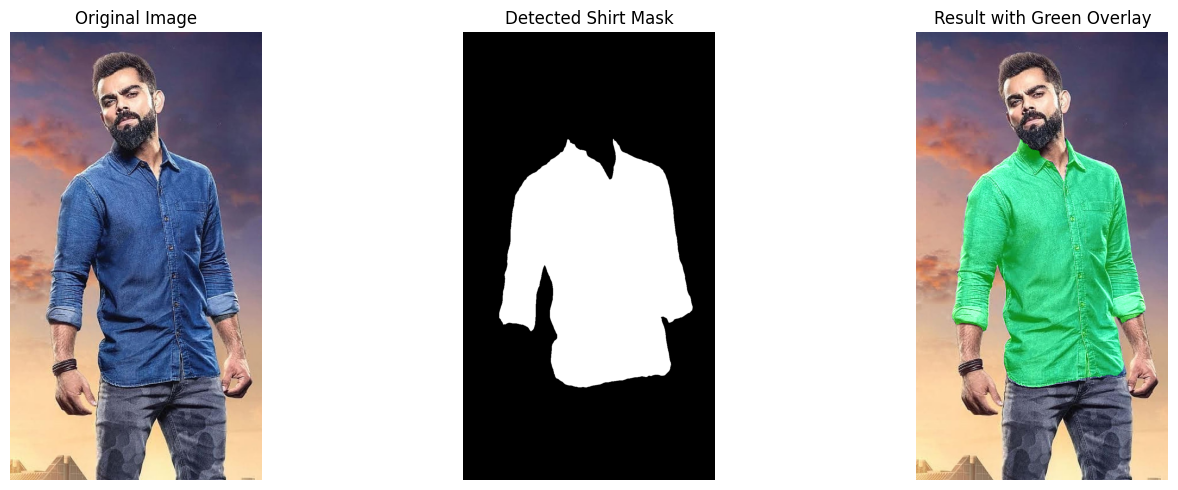

In [116]:
# Create green overlay
green = np.zeros_like(img_rgb)
green[:, :] = (0, 255, 0)  # Pure green in RGB

# Apply 50% transparent green overlay only to detected shirt regions
overlay = cv2.addWeighted(img_rgb, 1.0, green, 0.5, 0)
result = np.where(shirt_mask[:, :, np.newaxis] == 1, overlay, img_rgb)

# Optional: Display the detected shirt mask for verification
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(shirt_mask, cmap='gray')
plt.title('Detected Shirt Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(result)
plt.title('Result with Green Overlay')
plt.axis('off')

plt.tight_layout()
plt.show()
